                                        # Machine Learning Final Project 
                                       Models : XGBoost : RandomGridSearch with Weights 
                                       Sampling Methods : None 
                                       Creator : Sneha Vasudevan

References: 
- https://beckernick.github.io/oversampling-modeling/
- https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3
- https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa
- https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
- https://medium.com/turo-engineering/how-not-to-use-random-forest-265a19a68576
- https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm
- https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
- https://www.dataschool.io/comparing-supervised-learning-algorithms/
- https://www.kaggle.com/residentmario/oversampling-with-smote-and-adasyn
- https://stats.stackexchange.com/questions/255765/does-random-forest-need-input-variables-to-be-scaled-or-centered
- https://towardsdatascience.com/fraud-detection-under-extreme-class-imbalance-c241854e60c
- https://www.kaggle.com/karvalo/kaggle-2019-survey-eda (DATA)
- https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
- https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/ **(BASIS FOR CHOOSING XGBOOST)**


In [0]:
#Import Packages 
import pandas as pd
import numpy as np
import matplotlib as mpl
#from plotnine import *
import math
from math import *

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data-processing modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

# Modeling and evaluation modules 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification


# Sampling : 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
    
#warnings 
import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility 
SEED = 42

In [0]:
#Import Dataset - df_new
# 1. Import full data set using Pandas:
#df = pd.read_csv("df_new.csv", low_memory= False)
#df.shape

In [0]:
# Set up shared drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load dataset 
datapath = '/content/drive/Shared drives/Machine Learning/Code/df_new.csv'
df = pd.read_csv(datapath)
df.shape

(6362620, 22)

In [0]:
df.head(3)

,Unnamed: 0,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,day,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,0,0,0,1,0,0,1,1,0,0,0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,0,0,0,0,1,0,0,1,1,0,0,0
2,2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00,0,0,0,0,0,1,1,0,1,0,0,0


In [0]:
#removing first column
df = df.drop(df.columns[0], axis = 1)

In [0]:
df.shape

(6362620, 21)

In [0]:
# dropping Step. Column Day created from Step will be used instead. 
df = df.drop('step', axis=1) 

In [0]:
df.head(1)

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,day,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
0,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,0,0,0,1,0,0,1,1,0,0,0


In [0]:
df.shape

(6362620, 20)

In [0]:
#Creating X dataframe (predictors). 
#It should include every feature except for the target variable which is "isFraud".
X = df.drop('isFraud', axis=1) 
X.shape

(6362620, 19)

In [0]:
y = df['isFraud']
count = y.value_counts() # data is unbalanced
#y.head(1)

In [0]:
y.shape

(6362620,)

#### Train Test Split 

In [0]:
#Split into train / test set using an 80/20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2,random_state=SEED) #random state = SEED 

In [0]:
#X_train.head(5)

# XGBoost - Randomized Grid Search with scaled weights

In [0]:
#count = y.value_counts()
fraud = count[1] # positive
notfraud = count[0] # negative 
#fraud
#notfraud

In [0]:
fraud

8213

In [0]:
notfraud

6354407

In [0]:
#https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
#https://github.com/microsoft/LightGBM/issues/1299
ratio = sqrt(notfraud/fraud) # used sqrt to limit the effect of a multiplication of positive examples by a very high weight, since we have a very unbalanced dataset.
ratio

27.815482804507912

In [0]:
# Create a XGBoost instance 
xgb = XGBClassifier(random_state=SEED,scale_pos_weight=ratio)
# Fit on X_train and y_train
#xgb_fit = xgb.fit(X_train_scaled,y_train)
# Predict test data 
#y_pred_xgb_test = xgb.predict(X_test_scaled)

n_estimators = list(np.arange(100,1050,50,dtype=int))
#n_estimators 

learning_rate = list(np.arange(0.2,1.7,.1,dtype=float))
#learning_rate

gamma = list(np.arange(0,5.25,.25,dtype=float))
#gamma

xgb_param_grid = {
     'n_estimators'    : n_estimators ,
     'learning_rate'   : learning_rate, 
     'max_depth'       : [1,2,3],
     'gamma' : gamma,
}

xgb_Grid = RandomizedSearchCV(xgb, xgb_param_grid, cv = 3, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose= 5)
xgb_Grid = xgb_Grid.fit(X_train,y_train)

#find best estimator from RandomizedSearchCV to predict on test data.
xgb_Grid_best_estimator = xgb_Grid.best_estimator_

#Use best estimator from RandomizedSearchCV to predict on test data.
y_pred_xgb_Grid_bestmodel_test = xgb_Grid_best_estimator.predict(X_test)

# Generate confusion matrix and classification report                                           
cm_xgb_Grid_test = metrics.confusion_matrix(y_test, y_pred_xgb_Grid_bestmodel_test)
clr_xgb_Grid_test = metrics.classification_report(y_test, y_pred_xgb_Grid_bestmodel_test,output_dict=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 72.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 179.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 179.7min finished


[00:31:29] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [0]:
xgb_Grid_best_estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=4.0,
              learning_rate=0.8000000000000003, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=550, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27.815482804507912,
              seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
xgb_Grid.best_params_

{'gamma': 4.0,
 'learning_rate': 0.8000000000000003,
 'max_depth': 1,
 'n_estimators': 550}

In [0]:
# Calculate predicted probabilities 
y_prob_xgb_Grid_bestmodel_test  = xgb_Grid_best_estimator.predict_proba(X_test)
# Calculate roc_auc_score for class 1 
xgb_Grid_roc_auc_test = metrics.roc_auc_score(y_test, y_prob_xgb_Grid_bestmodel_test[:,1])
print(xgb_Grid_roc_auc_test)

0.9997378273804927


In [0]:
# Print confusion matrix 
print(cm_xgb_Grid_test)

[[1270850      31]
 [      4    1639]]


In [0]:
# extracting TP, TN, FP, and FN values from CM 
TN_xgb_test, FP_xgb_test, FN_xgb_test, TP_xgb_test = confusion_matrix(y_test, y_pred_xgb_Grid_bestmodel_test).ravel()
print(TN_xgb_test, FP_xgb_test, FN_xgb_test, TP_xgb_test)  

1270850 31 4 1639


In [0]:
# True positive 
TPR_xgb_test = TP_xgb_test/(TP_xgb_test+FN_xgb_test)

In [0]:
#false positive rate 
FPR_xgb_test = FP_xgb_test/(FP_xgb_test+TN_xgb_test)

In [0]:
# True Negative
TNR_xgb_test = TN_xgb_test/(TN_xgb_test+FP_xgb_test)

In [0]:
# False Negative 
FNR_xgb_test = FN_xgb_test/(TP_xgb_test+FN_xgb_test)

In [0]:
# Print classification report
clr_xgb_Grid_test

{'0': {'f1-score': 0.9999862298784099,
  'precision': 0.9999968525102018,
  'recall': 0.9999756074722967,
  'support': 1270881},
 '1': {'f1-score': 0.9894355568970721,
  'precision': 0.981437125748503,
  'recall': 0.9975654290931223,
  'support': 1643},
 'accuracy': 0.9999724956071555,
 'macro avg': {'f1-score': 0.994710893387741,
  'precision': 0.9907169891293524,
  'recall': 0.9987705182827096,
  'support': 1272524},
 'weighted avg': {'f1-score': 0.9999726075375279,
  'precision': 0.9999728894013963,
  'recall': 0.9999724956071555,
  'support': 1272524}}

In [0]:
# Predict train data 
y_pred_xgb_Grid_train = xgb_Grid_best_estimator.predict(X_train)

# Generate confusion matrix and classification report 
cm_xgb_Grid_train = metrics.confusion_matrix(y_train, y_pred_xgb_Grid_train)
clr_xgb_Grid_train = metrics.classification_report(y_train,y_pred_xgb_Grid_train,output_dict=True)

In [0]:
# Print confusion matrix
print(cm_xgb_Grid_train)

[[5083397     129]
 [     30    6540]]


In [0]:
# extracting TP, TN, FP, and FN values from CM 
TN_xgb_train, FP_xgb_train, FN_xgb_train, TP_xgb_train = confusion_matrix(y_train,y_pred_xgb_Grid_train).ravel()
print(TN_xgb_train, FP_xgb_train, FN_xgb_train, TP_xgb_train)  

5083397 129 30 6540


In [0]:
# True positive 
TPR_xgb_train = TP_xgb_train/(TP_xgb_train+FN_xgb_train)

In [0]:
#false positive rate 
FPR_xgb_train = FP_xgb_train/(FP_xgb_train+TN_xgb_train)

In [0]:
# True Negative
TNR_xgb_train = TN_xgb_train/(TN_xgb_train+FP_xgb_train)

In [0]:
# False Negative 
FNR_xgb_train = FN_xgb_train/(TP_xgb_train+FN_xgb_train)

In [0]:
# Print classification report
clr_xgb_Grid_train

{'0': {'f1-score': 0.9999843610961907,
  'precision': 0.9999940984693987,
  'recall': 0.9999746239126149,
  'support': 5083526},
 '1': {'f1-score': 0.9879900294584183,
  'precision': 0.9806567701304544,
  'recall': 0.9954337899543378,
  'support': 6570},
 'accuracy': 0.9999687628681266,
 'macro avg': {'f1-score': 0.9939871952773045,
  'precision': 0.9903254342999266,
  'recall': 0.9977042069334764,
  'support': 5090096},
 'weighted avg': {'f1-score': 0.9999688795102128,
  'precision': 0.9999691389701698,
  'recall': 0.9999687628681266,
  'support': 5090096}}

In [0]:
# Calculate predicted probabilities 
y_prob_xgb_Grid_bestmodel_train  = xgb_Grid_best_estimator.predict_proba(X_train)
# Calculate roc_auc_score for class 1 
xgb_Grid_roc_auc_train = metrics.roc_auc_score(y_train, y_prob_xgb_Grid_bestmodel_train[:,1])
print(xgb_Grid_roc_auc_train)

0.9997416188506333


In [0]:
MSE_xgb_test = mean_squared_error(y_test, y_pred_xgb_Grid_bestmodel_test)
print('Mean squared error - Test: %.4f'
      % MSE_xgb_test)

Mean squared error - Test: 0.0000


In [0]:
MSE_xgb_train = mean_squared_error(y_train,y_pred_xgb_Grid_train)
print('Mean squared error - Train: %.4f'
      % MSE_xgb_train)

Mean squared error - Train: 0.0000


In [0]:
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, y_pred_xgb_Grid_bestmodel_test)
fpr_xgb_train, tpr_xgb_train, thresholds_xgb_train = roc_curve(y_train,y_pred_xgb_Grid_train)

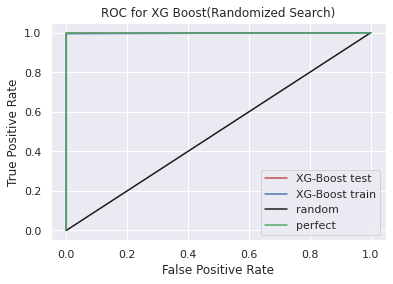

In [0]:
plt.title('ROC for XG Boost(Randomized Search)')
plt.plot(fpr_xgb_test, tpr_xgb_test,'r-',label = 'XG-Boost test')
plt.plot(fpr_xgb_train,tpr_xgb_train,'b-', label= 'XG-Boost train')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

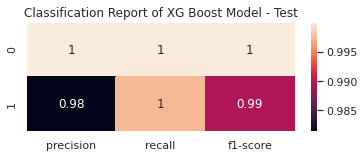

In [0]:
# Print classification report
#print(clr_xgb_Grid_test)
df7 = pd.DataFrame(clr_xgb_Grid_test).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df7, annot=True)
plt.title("Classification Report of XG Boost Model - Test")
ax.set_ylim(len(df7)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

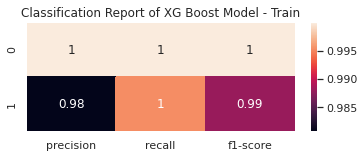

In [0]:
# Print classification report
#print(clr_xgb_Grid_train)
df8 = pd.DataFrame(clr_xgb_Grid_train).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df8, annot=True)
plt.title("Classification Report of XG Boost Model - Train")
ax.set_ylim(len(df8)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

# **Models Summary** 

In [0]:
models_summary_test = [['XGBoost ',TPR_xgb_test,FPR_xgb_test,TNR_xgb_test,FNR_xgb_test,xgb_Grid_roc_auc_test,MSE_xgb_test]]
models_summary_test_df = pd.DataFrame(models_summary_test,columns=['Test Model','True Positive Rate','False Positive Rate','True Negative Rate','False Negative Rate','AUC score','MSE'])
models_summary_test_df

,Test Model,True Positive Rate,False Positive Rate,True Negative Rate,False Negative Rate,AUC score,MSE
0,XGBoost,0.997565,0.000024,0.999976,0.002435,0.999738,0.000028


In [0]:
models_summary_train = [['XGBoost ',TPR_xgb_train,FPR_xgb_train,TNR_xgb_train,FNR_xgb_train,xgb_Grid_roc_auc_train,MSE_xgb_train]]
models_summary_train_df = pd.DataFrame(models_summary_train,columns=['Train Model','True Positive Rate','False Positive Rate','True Negative Rate','False Negative Rate','AUC score','MSE'])
models_summary_train_df

,Train Model,True Positive Rate,False Positive Rate,True Negative Rate,False Negative Rate,AUC score,MSE
0,XGBoost,0.995434,0.000025,0.999975,0.004566,0.999742,0.000031


In this model, we adjusted the weights of the XGBoost classifier to account for the imbalance in data. The actual weight should have been **780/1**, however, the weights were calculated to be **sqrt(780:1)**. I used sqrt to limit the effect of a multiplication of positive examples by a very high weight, since we have a very unbalanced dataset.

Based on the model summary, I feel that the XGBoost classifier did a great job with classificying the fraud data. As we can see above, the model performance in terms of Train vs Test (FPR, FNR) are pretty similar, infact test has lower FPR and FNR. Due to similar performance between the train and test , I do not believe there is any sign of overfitting. 